In [10]:
import pyarrow.parquet as parquet
import pyarrow.feather as feather
import pyarrow.orc as orc
import pyarrow.csv as csv
import pandas as pd
from timeit import default_timer as timer
from datetime import timedelta

reddit_place = '2022_place_canvas_history'
parquet_file = f'data/small/day1/{reddit_place}.parquet'
feather_file = f'data/small/day1/{reddit_place}.feather'
orc_file = f'data/small/day1/{reddit_place}.orc'
csv_file = f'data/small/day1/{reddit_place}.csv'


def time_func(func, *args, **kwargs):
    start = timer()
    #print(f'Starting {func.__name__}: [{start}]')
    result = func(*args, **kwargs)
    end = timer()
    #print(f'Done {func.__name__}: [{end}]')
    total_in_seconds = end - start
    print(f'Total time: {timedelta(seconds=total_in_seconds)}')

    return result, total_in_seconds


def entire_file_to_df(filename, filetype):
    """Read entire file convert df and get shape"""
    if filetype == 'parquet':
        df = parquet.read_table(filename).to_pandas()
    elif filetype == 'orc':
        df = orc.read_table(filename).to_pandas()
    elif filetype == 'feather':
        df = feather.read_feather(filename)
    elif filetype == 'csv':
        df = csv.read_csv(filename).to_pandas()
    
    return df.shape


def get_amount_participants(filename, filetype):
    """User_id is a column with high variety"""
    if filetype == 'parquet':
        df = parquet.read_table(filename, columns=['user_id']).to_pandas()
    elif filetype == 'orc':
        df = orc.read_table(filename, columns=['user_id']).to_pandas()
    elif filetype == 'feather':
        df = feather.read_feather(filename, columns=['user_id'])
    elif filetype == 'csv':
        df = csv.read_csv(filename).to_pandas()
    
    return pd.unique(df['user_id']).shape[0]


def get_amount_colors_used(filename, filetype):
    """Pixel color is low variety 16 unique values"""
    if filetype == 'parquet':
        df = parquet.read_table(filename, columns=['pixel_color']).to_pandas()
    elif filetype == 'orc':
        df = orc.read_table(filename, columns=['pixel_color']).to_pandas()
    elif filetype == 'feather':
        df = feather.read_feather(filename, columns=['pixel_color'])
    elif filetype == 'csv':
        df = csv.read_csv(filename).to_pandas()
    
    return pd.unique(df['pixel_color']).shape[0]


def get_number_of_rows(filename, filetype):        
    """Row count"""
    if filetype == 'parquet':
        num_rows = parquet.read_metadata(filename).num_rows
    elif filetype == 'orc':
        num_rows = orc.read_table(filename).num_rows
    elif filetype == 'feather':
        num_rows = feather.read_table(filename).num_rows
    elif filetype == 'csv':
        num_rows = csv.read_csv(filename).num_rows
    
    return num_rows


In [11]:
def query_test(func, filenames, filetypes):
    results = []
    for filename, filetype in zip(filenames, filetypes):
        result = time_func(
            func,
            filename,
            filetype
        )

        results.append({
            'filename': filename,
            'filetype': filetype,
            'func_return': result[0],
            'time_in_seconds': result[1]
        })

    return results

In [12]:
functions = [
    entire_file_to_df,
    get_amount_participants, 
    get_amount_colors_used,
    get_number_of_rows
]
filenames = [parquet_file, orc_file, feather_file, csv_file]
filetypes = ['parquet', 'orc', 'feather', 'csv']

all_tests = []
for i in range(10):
    query_tests = []
    for f in functions:
        print(f'Running {f.__name__}')
        results = query_test(f, filenames, filetypes)
        print('----------\n')
        query_tests.append({
            'function': f.__name__,
            'results': results
        })

    all_tests.append(query_tests)


import json
with open('results.json', 'w', encoding='utf8') as jfile:
    json.dump(all_tests, jfile, indent=4)

Running entire_file_to_df
Total time: 0:00:12.692349
Total time: 0:00:11.929314
Total time: 0:00:11.665468
Total time: 0:00:12.347115
----------

Running get_amount_participants
Total time: 0:00:09.032898
Total time: 0:00:07.937460
Total time: 0:00:08.091165
Total time: 0:00:13.685723
----------

Running get_amount_colors_used
Total time: 0:00:00.651497
Total time: 0:00:00.630769
Total time: 0:00:00.539182
Total time: 0:00:09.337122
----------

Running get_number_of_rows
Total time: 0:00:00.000390
Total time: 0:00:01.538170
Total time: 0:00:00.458758
Total time: 0:00:00.767572
----------

Running entire_file_to_df
Total time: 0:00:10.592698
Total time: 0:00:09.687964
Total time: 0:00:08.767997
Total time: 0:00:09.043322
----------

Running get_amount_participants
Total time: 0:00:09.079783
Total time: 0:00:08.139873
Total time: 0:00:08.130765
Total time: 0:00:13.371398
----------

Running get_amount_colors_used
Total time: 0:00:00.651671
Total time: 0:00:00.651380
Total time: 0:00:00.5

In [59]:
import matplotlib.colors
color_groups = pd.Series(get_most_popular_colors(parquet_file, 'parquet'))
colors = [matplotlib.colors.to_rgba(c) for c in color_groups.index]

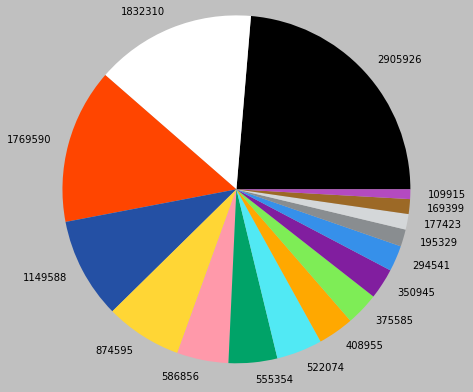

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_facecolor('silver')
ax.pie(
    color_groups, 
    colors=colors, 
    labels=[*color_groups],
    textprops={'color': 'black'}, 
    radius=2
)
ax.set_facecolor('silver')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.show()

In [2]:
import numpy as np
import matplotlib.colors
from tqdm import tqdm
from PIL import Image

df = parquet.read_table(parquet_file).to_pandas()
gb = df.groupby('coordinate').agg({'conv_timestamp': 'max'})
cdf = pd.merge(left=gb, right=df, on=['coordinate', 'conv_timestamp'], how='inner')
mask = cdf['coordinate'].value_counts() > 1
cdf['coordinate'].value_counts()[mask].count()

In [64]:
image = np.zeros(shape=(1000, 1000, 3), dtype='uint8')

for index, row in tqdm(df.iterrows()):
    color = matplotlib.colors.to_rgb(row['pixel_color'])
    r, g, b = color

    x, y, *rest = [int(v.strip()) for v in row['coordinate'].split(',')]
    if rest:
        print(row['coordinate'])
    image[y][x][0] = r * 256
    image[y][x][1] = g * 256
    image[y][x][2] = b * 256
    if index > 500000:
        break


im = Image.fromarray(image, 'RGB')
im.save('reddit.png')